# Adversarial attack on MNIST classifier

### Imports

In [5]:
import torchvision
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Get MNIST Dataset

In [6]:
!rm -rf /content/data
!mkdir /content/data

In [7]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST('./', download=True,
                    transform=transforms.Compose([
                    transforms.ToTensor(),
                    ]), train=True)


test_set = MNIST('./', download=True,
                transform=transforms.Compose([
                transforms.ToTensor(),
                ]), train=False)

--2021-03-20 13:41:05--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-20 13:41:05--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [              <=>   ]  33.20M  11.2MB/s    in 3.0s    

2021-03-20 13:41:09 (11.2 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [279]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=42,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                         shuffle=False, num_workers=2)

### Model

In [288]:
device = torch.device('cuda')

In [289]:
class LeNet(nn.Module):
    def __init__(self, n_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc2 = nn.Linear(120, n_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x

In [296]:
def accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            logits = model(X)
            probs = F.softmax(logits, dim=1)
            y_pred = torch.argmax(probs, 1)

            n += y_true.size(0)
            correct_pred += (y_pred == y_true).sum()

    return correct_pred.float() / n

In [297]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y_true = y_true.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [298]:
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [299]:
def training(model, 
            criterion, 
            optimizer, 
            train_loader, 
            valid_loader,
            epochs,
            device):
    
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            
        train_acc = accuracy(model, train_loader, device=device)
        valid_acc = accuracy(model, valid_loader, device=device)
            
        print(f'Epoch: {epoch}  '
              f'Train loss: {train_loss:.4f}  '
              f'Valid loss: {valid_loss:.4f}  '
              f'Train accuracy: {train_acc:.2f}  '
              f'Valid accuracy: {valid_acc:.2f}')
    
    return model, optimizer, (train_losses, valid_losses)

### Training

In [300]:
lr = 1e-3
epochs = 15
model = LeNet(n_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [301]:
model, _, losses = training(model,
                            criterion, 
                            optimizer, 
                            train_loader, 
                            test_loader, 
                            epochs, 
                            device)

Epoch: 0  Train loss: 0.4229  Valid loss: 0.0949  Train accuracy: 0.97  Valid accuracy: 0.97
Epoch: 1  Train loss: 0.1934  Valid loss: 0.0740  Train accuracy: 0.98  Valid accuracy: 0.98
Epoch: 2  Train loss: 0.1545  Valid loss: 0.0510  Train accuracy: 0.98  Valid accuracy: 0.98
Epoch: 3  Train loss: 0.1326  Valid loss: 0.0468  Train accuracy: 0.98  Valid accuracy: 0.98
Epoch: 4  Train loss: 0.1214  Valid loss: 0.0417  Train accuracy: 0.99  Valid accuracy: 0.99
Epoch: 5  Train loss: 0.1129  Valid loss: 0.0371  Train accuracy: 0.99  Valid accuracy: 0.99
Epoch: 6  Train loss: 0.1075  Valid loss: 0.0353  Train accuracy: 0.99  Valid accuracy: 0.99
Epoch: 7  Train loss: 0.1008  Valid loss: 0.0369  Train accuracy: 0.99  Valid accuracy: 0.99
Epoch: 8  Train loss: 0.0977  Valid loss: 0.0345  Train accuracy: 0.99  Valid accuracy: 0.99
Epoch: 9  Train loss: 0.0912  Valid loss: 0.0350  Train accuracy: 0.99  Valid accuracy: 0.99
Epoch: 10  Train loss: 0.0895  Valid loss: 0.0338  Train accuracy: 0.9

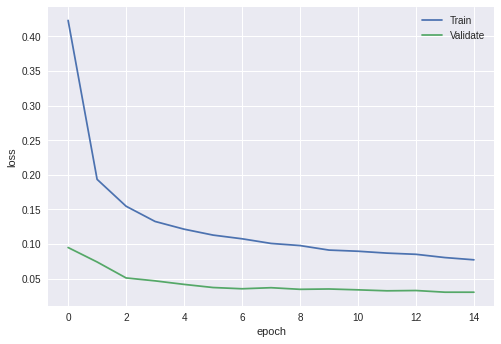

In [304]:
plt.style.use('seaborn')
train_losses, val_losses = map(np.array, losses) 
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validate')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Adversarial attack

In [323]:
def apply_attack(model, device, test_loader, eps):
    correct = 0
    adv_examples = []

    for X, y in test_loader:

        X, y = X.to(device), y.to(device)
        X.requires_grad = True
        logits = model(X)
        output = F.softmax(logits, dim=1)
        pred = output.max(1, keepdim=True)[1]

        if pred.item() != y.item():
            continue

        loss = F.nll_loss(output, y)
        model.zero_grad()
        loss.backward()
        grad = X.grad.data

        # FGSM attack
        adv_data = X + eps * grad.sign()
        adv_data = torch.clamp(adv_data, 0, 1)
        output = model(adv_data)
        output = F.softmax(output, dim=1)

        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == y.item():
            correct += 1
        else:
            adv_ex = adv_data.squeeze().detach().cpu().numpy()
            adv_examples.append((pred.item(), final_pred.item(), adv_ex))

    acc = correct / float(len(test_loader))
    print("Accuracy = {}".format(acc))

    return acc, adv_examples

In [324]:
model.eval()

accuracies = []
examples = []
epsilon = 0.15

acc, ex = apply_attack(model, device, test_loader, epsilon)
accuracies.append(acc)
examples.append(ex)

Accuracy = 0.6128


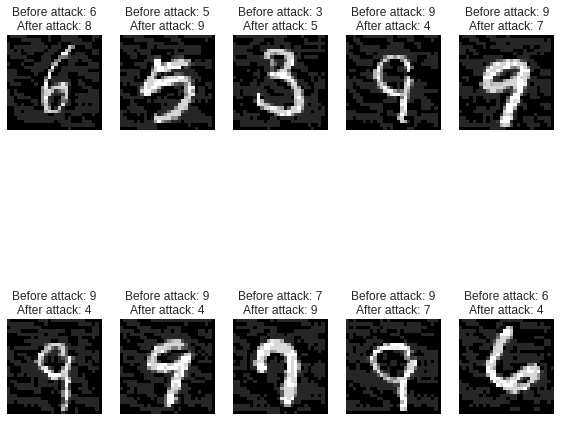

In [328]:
cnt = 0
plt.figure(figsize=(8,10))

for _ in range(10):
    ind = np.random.randint(len(examples[0]))
    target, adv, adv_img = examples[0][ind]
    cnt += 1
    plt.subplot(2, 5, cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Before attack: {}\nAfter attack: {}".format(target, adv))
    plt.imshow(adv_img, cmap="gray")
plt.tight_layout()
plt.show()